# Import

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib 

from sklearn.neural_network import MLPClassifier

# Optional: Configure visualisations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


# Warning suppression
import warnings
warnings.filterwarnings('ignore')

# Étape 1 : Chargement et Prétraitement des Données

In [10]:
# Load the Titanic dataset

data = pd.read_csv('Titanic-Dataset.csv')

# --- Initial Exploration (Brief) ---
print("--- Aperçu des données initiales ---")
print(data.head())
print("\n--- Informations sur le dataset ---")
data.info()
print("\n--- Valeurs manquantes par colonne ---")
print(data.isnull().sum())

# --- Prétraitement ---
print("\n--- Début du prétraitement ---")

# Target variable
y = data['Survived']
X = data.drop('Survived', axis=1)

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# Remove features that are difficult to use directly or have too many unique values for this exercise
# PassengerId is just an identifier
# Name might require complex NLP
# Ticket is often not very informative without significant feature engineering
# Cabin has too many missing values, though one could engineer 'HasCabin'
features_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
X_reduced = X.drop(columns=features_to_drop)

# Update feature lists after dropping
numerical_features = [f for f in numerical_features if f not in features_to_drop]
categorical_features = [f for f in categorical_features if f not in features_to_drop]

print(f"\nCaractéristiques numériques conservées : {numerical_features}")
print(f"Caractéristiques catégorielles conservées : {categorical_features}")


# Create preprocessing pipelines for numerical and categorical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Impute missing ages with median
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing Embarked with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # handle_unknown is important
])

# Create a column transformer to apply pipelines to the correct columns
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features)
], remainder='passthrough') # Keep other columns (if any)

# Apply the preprocessing
X_processed = preprocessor.fit_transform(X_reduced)

# Get feature names after one-hot encoding for better interpretability later
# These names are crucial for understanding the Logistic Regression coefficients
try:
    ohe_feature_names = preprocessor.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_features)
    processed_feature_names = numerical_features + list(ohe_feature_names)
except AttributeError: # Older scikit-learn might not have get_feature_names_out
    print("Warning: Could not automatically retrieve feature names from OneHotEncoder. Coefficients might be harder to interpret.")
    # Fallback to generic names if needed, or handle based on scikit-learn version
    processed_feature_names = None


# Convert X_processed back to a DataFrame (optional, but good for inspection)
if processed_feature_names:
    X_processed_df = pd.DataFrame(X_processed, columns=processed_feature_names)
else:
    X_processed_df = pd.DataFrame(X_processed)


print("\n--- Dimensions de X après prétraitement ---")
print(X_processed_df.shape)
print("\n--- Aperçu de X après prétraitement ---")
print(X_processed_df.head())

# --- Enregistrement des données prétraitées (X_processed_df et y) ---
# Note: y (target) doesn't usually need saving separately unless it underwent transformation,
# but we'll save them as X_preprocessed.csv and y_preprocessed.csv for clarity
X_processed_df.to_csv('X_preprocessed.csv', index=False)
y.to_csv('y_preprocessed.csv', index=False, header=['Survived']) # Save y as a CSV too

print("\n--- Données prétraitées X_preprocessed.csv et y_preprocessed.csv enregistrées. ---")

# --- Séparation des données en ensembles d'entraînement et de test ---
X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dimensions de X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Dimensions de X_test: {X_test.shape}, y_test: {y_test.shape}")

--- Aperçu des données initiales ---
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0          

# Étape 2 : Entraînement et Évaluation du Modèle Black-Box

In [11]:
print("\n--- Entraînement du Modèle Black-Box (Random Forest) ---")

# Initialize Random Forest classifier
blackbox_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train the model
blackbox_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_blackbox = blackbox_model.predict(X_test)
y_proba_blackbox_test = blackbox_model.predict_proba(X_test)[:, 1] # Probabilities for AUC or soft labels if needed

# Evaluate the model
accuracy_blackbox = accuracy_score(y_test, y_pred_blackbox)
print(f"Accuracy du modèle Black-Box (Random Forest): {accuracy_blackbox:.4f}")
print("\nClassification Report du Black-Box:")
print(classification_report(y_test, y_pred_blackbox))
print("\nConfusion Matrix du Black-Box:")
print(confusion_matrix(y_test, y_pred_blackbox))

# ___ Enregistrement du modèle en Joblib____
joblib.dump(blackbox_model, 'blackbox_model.joblib')
print("\n--- Modèle blackbox_model.joblib enregistré. ---")


--- Entraînement du Modèle Black-Box (Random Forest) ---
Accuracy du modèle Black-Box (Random Forest): 0.8101

Classification Report du Black-Box:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179


Confusion Matrix du Black-Box:
[[97 13]
 [21 48]]

--- Modèle blackbox_model.joblib enregistré. ---


In [12]:
print("\n--- Entraînement du Modèle Black-Box (MLP) ---")

# Initialize MLP classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
# Train the model
mlp_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred_mlp = mlp_model.predict(X_test)
y_proba_mlp_test = mlp_model.predict_proba(X_test)[:, 1]  # Probabilities for AUC or soft labels if needed
# Evaluate the model
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Accuracy du modèle MLP: {accuracy_mlp:.4f}")
print("\nClassification Report du MLP:")
print(classification_report(y_test, y_pred_mlp))
print("\nConfusion Matrix du MLP:")
print(confusion_matrix(y_test, y_pred_mlp))


# ___ Enregistrement du modèle MLP en Joblib____
joblib.dump(mlp_model, 'mlp_model.joblib')
print("\n--- Modèle mlp_model.joblib enregistré. ---")


--- Entraînement du Modèle Black-Box (MLP) ---
Accuracy du modèle MLP: 0.7877

Classification Report du MLP:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       110
           1       0.77      0.64      0.70        69

    accuracy                           0.79       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179


Confusion Matrix du MLP:
[[97 13]
 [25 44]]

--- Modèle mlp_model.joblib enregistré. ---


# Étape 3 : Implémentation de la Fonction de Distillation et Entraînement du Modèle Étudiant

In [14]:
print("\n--- Distillation du Modèle (Régression Logistique) ---")

def distill_logistic_regression(X_data_for_distillation, path_to_blackbox_model):
    """
    Entraîne un modèle de Régression Logistique (étudiant) pour mimer les prédictions
    d'un modèle black-box (professeur) sur les données fournies.

    Args:
        X_data_for_distillation (pd.DataFrame or np.array): Les caractéristiques sur lesquelles
                                                            le black-box fera des prédictions,
                                                            et sur lesquelles l'étudiant sera entraîné.
                                                            (Selon votre demande, ce sera X_test_preprocessed)
        path_to_blackbox_model (str): Chemin vers le modèle black-box sauvegardé (.pkl).

    Returns:
        LogisticRegression: Le modèle de régression logistique entraîné (étudiant).
    """
    # Charger le modèle black-box
    loaded_blackbox_model = joblib.load(path_to_blackbox_model)

    # Obtenir les prédictions du black-box sur X_data_for_distillation
    # Ce seront les "labels cibles" pour notre modèle étudiant
    # Utiliser les prédictions directes (0 ou 1) pour une distillation simple (hard labels)
    blackbox_predictions_for_student = loaded_blackbox_model.predict(X_data_for_distillation)

    # Initialiser et entraîner le modèle de Régression Logistique (étudiant)
    student_model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
    student_model.fit(X_data_for_distillation, blackbox_predictions_for_student)

    print("Modèle étudiant (Régression Logistique) entraîné sur les prédictions du black-box.")
    return student_model


# Récupérer les données prétraitées pour distillation
data_x = pd.read_csv('X_preprocessed.csv')
data_y = pd.read_csv('y_preprocessed.csv')

# Séparation des données prétraitées pour distillation
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)



print("\nEntraînement du modèle étudiant sur X_test (comme demandé)...")
distilled_logistic_model = distill_logistic_regression(X_train, 'blackbox_model.joblib')

# Sauvegarder le modèle distillé (optionnel)
joblib.dump(distilled_logistic_model, 'distilled_logistic_model.pkl')
print("--- Modèle distilled_logistic_model.pkl enregistré. ---")


--- Distillation du Modèle (Régression Logistique) ---

Entraînement du modèle étudiant sur X_test (comme demandé)...
Modèle étudiant (Régression Logistique) entraîné sur les prédictions du black-box.
--- Modèle distilled_logistic_model.pkl enregistré. ---


# Étape 4 : Comparaison des Performances et Importance des Caractéristiques


--- Comparaison des Performances sur l'ensemble de Test (y_test original) ---
Accuracy du Black-Box (Random Forest) sur y_test: 0.8101
Accuracy du Modèle Distillé (Rég. Log.) sur y_test: 0.7989

Classification Report du Modèle Distillé sur y_test:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       110
           1       0.72      0.78      0.75        69

    accuracy                           0.80       179
   macro avg       0.79      0.80      0.79       179
weighted avg       0.80      0.80      0.80       179


Confusion Matrix du Modèle Distillé sur y_test:
[[89 21]
 [15 54]]

Fidélité du Modèle Distillé au Black-Box sur X_test: 0.8212
(La fidélité mesure à quel point l'étudiant imite le professeur sur X_test)

--- Importance des Caractéristiques (Coefficients de la Régression Logistique) ---
      Feature  Coefficient
5  Sex_female     1.414701
8  Embarked_Q     0.335603
4        Fare     0.165626
7  Embarked_C     0.099667


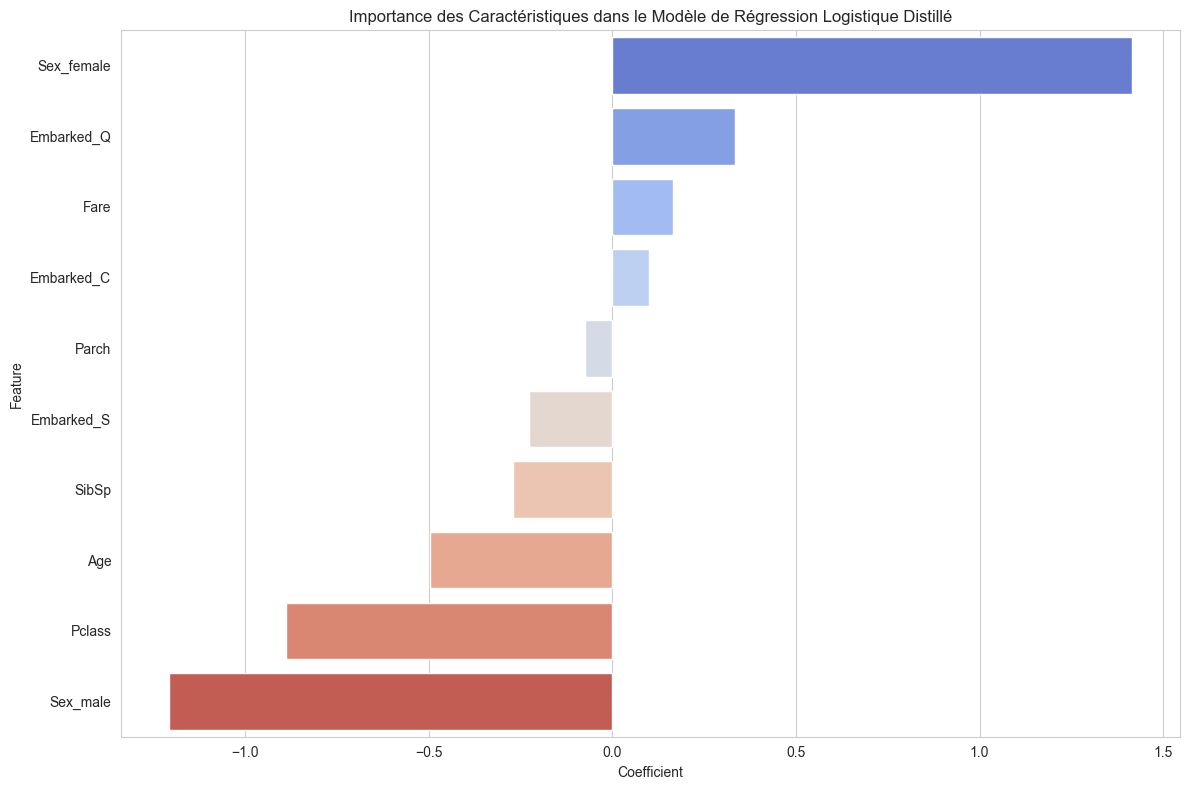

In [5]:
print("\n--- Comparaison des Performances sur l'ensemble de Test (y_test original) ---")

# 1. Performance du Black-Box (déjà calculée, mais rappelons-la)
print(f"Accuracy du Black-Box (Random Forest) sur y_test: {accuracy_blackbox:.4f}")

# 2. Performance du Modèle Distillé (Régression Logistique) sur y_test
# Le modèle distillé a été entraîné pour mimer le black-box.
y_pred_distilled = distilled_logistic_model.predict(X_test)
accuracy_distilled = accuracy_score(y_test, y_pred_distilled) # Évaluation par rapport aux vrais labels
print(f"Accuracy du Modèle Distillé (Rég. Log.) sur y_test: {accuracy_distilled:.4f}")

print("\nClassification Report du Modèle Distillé sur y_test:")
print(classification_report(y_test, y_pred_distilled))
print("\nConfusion Matrix du Modèle Distillé sur y_test:")
print(confusion_matrix(y_test, y_pred_distilled))


# 3. Fidélité du Modèle Distillé au Black-Box
blackbox_preds_on_test = blackbox_model.predict(X_test) # Prédictions du black-box sur X_test
student_preds_on_test_for_fidelity = distilled_logistic_model.predict(X_test) # Prédictions de l'étudiant sur X_test

fidelity = accuracy_score(blackbox_preds_on_test, student_preds_on_test_for_fidelity)
print(f"\nFidélité du Modèle Distillé au Black-Box sur X_test: {fidelity:.4f}")
print("(La fidélité mesure à quel point l'étudiant imite le professeur sur X_test)")


print("\n--- Importance des Caractéristiques (Coefficients de la Régression Logistique) ---")
# S'assurer que X_train.columns correspond aux caractéristiques utilisées par la régression logistique
# Si X_processed_df a été utilisé pour le split, ses colonnes sont les bonnes.
if processed_feature_names:
    feature_names_for_lr = processed_feature_names
elif hasattr(X_train, 'columns'):
    feature_names_for_lr = X_train.columns
else:
    print("Impossible de récupérer les noms des caractéristiques pour les coefficients.")
    feature_names_for_lr = [f"feature_{i}" for i in range(X_train.shape[1])]


coefficients = distilled_logistic_model.coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names_for_lr, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

print(feature_importance)

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='coolwarm')
plt.title('Importance des Caractéristiques dans le Modèle de Régression Logistique Distillé')
plt.tight_layout()
plt.show()